In [1]:
# classification
from __future__ import print_function, division
import torch
import numpy as np
import torch.optim as optim
import data
from torch.utils.data import DataLoader
from torch.autograd import Variable
from collections import OrderedDict
import csvgenerator as csvg
import os
import matplotlib.pyplot as plt
from torchvision import transforms, utils, models
from model import survresnet
import torch.nn as nn

In [2]:
# print gpu
torch.cuda.set_device(0)
currentDevice = torch.cuda.current_device()
print("Current GPU: " + str(currentDevice))
print(str(torch.cuda.device_count()))
print(str(torch.cuda.get_device_capability(currentDevice)))
print(torch.__version__)

USE_GPU = 1
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = "cpu"
print(device)

Current GPU: 0
8
(7, 0)
1.0.0
cuda:0


In [3]:
# csvg.generate_csv()

/deepdata/adib/prognostic_study/pytorch_code/image_files.csv
1186513
0 torch.Size([20, 3, 224, 224]) torch.Size([20, 3, 224, 224])
1 torch.Size([20, 3, 224, 224]) torch.Size([20, 3, 224, 224])
2 torch.Size([20, 3, 224, 224]) torch.Size([20, 3, 224, 224])
3 torch.Size([20, 3, 224, 224]) torch.Size([20, 3, 224, 224])
torch.Size([20, 3, 224, 224])


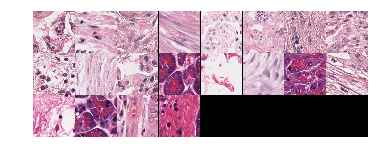

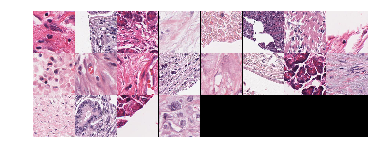

In [4]:
csvFilePath = csvg.get_csv_path()
print(csvFilePath)
transformed_dataset = data.HE_Dataset(csv_file=csvFilePath,
                                               transform=data.Compose([                                                                                  
                                               data.ToTensor()
                                           ]))
# TODO: change the normalization parameters

# batchsize 32->16
dataloader = DataLoader(transformed_dataset, batch_size=20,
                        shuffle=True, num_workers=0)
print(len(transformed_dataset))

data.show_patch(dataloader)

In [5]:
cwd = os.getcwd()
path = os.path.join(cwd, 'Saved model', 'surclassifier.pth')

state_dict = torch.load(path, map_location=torch.device('cuda:0'))
model = survresnet()
model.load_state_dict(state_dict)
model.eval()
model.to(device)

survresnet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Con

In [6]:
criterionCE = nn.CrossEntropyLoss()
criterionCE = criterionCE.to(device)

In [7]:
cwd = os.getcwd();
save_path = os.path.join(cwd, 'Saved model')
Save_generator_path=os.path.join(save_path,'surclassifier.pth')
Tensor = torch.cuda.LongTensor
pytorch_total_parms = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_parms)

42504258


In [14]:
torch.cuda.empty_cache()

In [8]:
def train(epoch, dataloader, criterion):
    epoch_loss = 0
    lr.step()
    for param_group in optimizer.param_groups:
        print(param_group['lr'])
    for iteration, batch in enumerate(dataloader):
        img_ser, img_dec = batch['input_sur'].float().to(device), batch['input_dec'].float().to(device)
        ser = Tensor(np.zeros(img_ser.size(0)))
        dec = Tensor(np.ones(img_dec.size(0)))
        
        inputs = torch.cat([img_ser, img_dec], dim=0)
        label_temp_ser = torch.cat([ser, dec], dim=0).unsqueeze(0)
        label_temp_dec = torch.cat([dec, ser], dim=0).unsqueeze(0)
        labels = torch.cat([label_temp_ser, label_temp_dec], dim=0).transpose(1, 0) 
        labels = Variable(labels, requires_grad=False) # ser:1, dec:0
                                   
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = torch.max(labels, 1)[1]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()      
    
        if iteration%100 == 0:
            print("lossCrossEntropy: " + str(loss.item()))
            print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(dataloader), loss.item()))
        
        if iteration%10000==0 and iteration!=0:
            torch.save(model.state_dict(), Save_generator_path) 
    torch.save(model.state_dict(), Save_generator_path)

In [9]:
def new_dataloader(batch_size=20):
    csvFilePath = csvg.get_csv_path()
    print(csvFilePath)
    transformed_dataset = data.HE_Dataset(csv_file=csvFilePath,
                                                   transform=data.Compose([                                                                                  
                                                   data.ToTensor()
                                               ]))
    dataloader = DataLoader(transformed_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=0)
    return dataloader

In [10]:
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)

In [ ]:
n_epochs = 100
lr = torch.optim.lr_scheduler.LambdaLR(
    optimizer, lr_lambda=LambdaLR(n_epochs, 0, 5).step
)
for epoch in range(0, n_epochs):
    train(epoch, new_dataloader(), criterionCE)  

/deepdata/adib/prognostic_study/pytorch_code/image_files.csv
0.001
lossCrossEntropy: 0.5824704170227051
===> Epoch[0](0/59326): Loss: 0.5825
lossCrossEntropy: 0.6171352863311768
===> Epoch[0](100/59326): Loss: 0.6171
lossCrossEntropy: 0.6345374584197998
===> Epoch[0](200/59326): Loss: 0.6345
lossCrossEntropy: 0.5740988254547119
===> Epoch[0](300/59326): Loss: 0.5741
lossCrossEntropy: 0.6423120498657227
===> Epoch[0](400/59326): Loss: 0.6423
lossCrossEntropy: 0.5793503522872925
===> Epoch[0](500/59326): Loss: 0.5794
lossCrossEntropy: 0.607730507850647
===> Epoch[0](600/59326): Loss: 0.6077
lossCrossEntropy: 0.5386343002319336
===> Epoch[0](700/59326): Loss: 0.5386
lossCrossEntropy: 0.647910475730896
===> Epoch[0](800/59326): Loss: 0.6479
lossCrossEntropy: 0.6044758558273315
===> Epoch[0](900/59326): Loss: 0.6045
lossCrossEntropy: 0.5911028385162354
===> Epoch[0](1000/59326): Loss: 0.5911
lossCrossEntropy: 0.5596460700035095
===> Epoch[0](1100/59326): Loss: 0.5596
lossCrossEntropy: 0.502

In [ ]:
n_epochs = 80
lr = torch.optim.lr_scheduler.LambdaLR(
    optimizer, lr_lambda=LambdaLR(n_epochs, 0, 0).step
)
for epoch in range(0, n_epochs):
    train(epoch, new_dataloader(), criterionCE)  

/deepdata/adib/prognostic_study/pytorch_code/image_files.csv
0.0008
lossCrossEntropy: 0.004013457801192999
===> Epoch[0](0/59326): Loss: 0.0040
lossCrossEntropy: 0.06719186902046204
===> Epoch[0](100/59326): Loss: 0.0672
lossCrossEntropy: 0.11396199464797974
===> Epoch[0](200/59326): Loss: 0.1140
lossCrossEntropy: 0.04864541441202164
===> Epoch[0](300/59326): Loss: 0.0486
lossCrossEntropy: 0.17611443996429443
===> Epoch[0](400/59326): Loss: 0.1761
lossCrossEntropy: 0.09060736000537872
===> Epoch[0](500/59326): Loss: 0.0906
lossCrossEntropy: 0.05565208941698074
===> Epoch[0](600/59326): Loss: 0.0557
lossCrossEntropy: 0.013309394009411335
===> Epoch[0](700/59326): Loss: 0.0133
lossCrossEntropy: 0.05269019678235054
===> Epoch[0](800/59326): Loss: 0.0527
lossCrossEntropy: 0.0201679989695549
===> Epoch[0](900/59326): Loss: 0.0202
lossCrossEntropy: 0.11778359115123749
===> Epoch[0](1000/59326): Loss: 0.1178
lossCrossEntropy: 0.001942774630151689
===> Epoch[0](1100/59326): Loss: 0.0019
lossCr